In [1]:
import os
import cv2
import numpy as np
from PIL import Image
from dataclasses import dataclass
import matplotlib.pyplot as plt
import japanize_matplotlib
from glob import glob
from pathlib import Path
import os
import cv2
import numpy as np
from PIL import Image
from dataclasses import dataclass
from glob import glob
from pathlib import Path

from utils import Range, ColorRange, filter_blue, focus_yellow, to_pil, run_focusing_yellow, COLOR_RANGE, draw_from_binary_mask, draw_bbox, get_weak_reflection_parts

neG9vU93uB


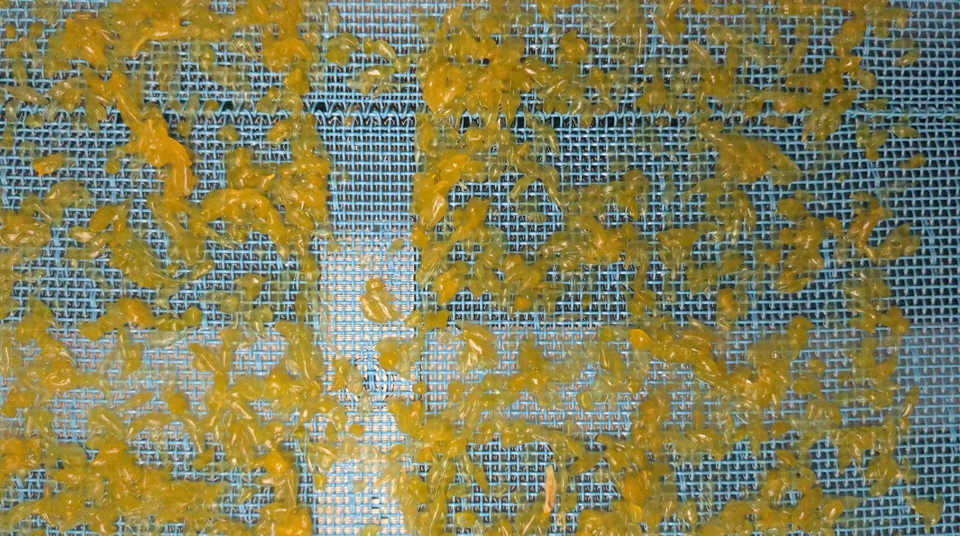

In [2]:
stems = [Path(p).stem for p in glob("comp/*.png")]
MASK_ROOT = "/home/yamagami/works/ishida/okamoto_anormally_detection/datasets_okamoto/label_studio_VID_20240124_163346/mask"
obj_masks = {s: cv2.imread(os.path.join(MASK_ROOT, f"{s}.png")) for s in stems}

# STEM = "_G18U-l4FL"
STEM = stems[5]
print(STEM)

ROOT = f"checkpoints/dsrnet_s_test/20240603-165422/test/{STEM}"
# origin_image = f"comp/{STEM}.png"
origin_image_p = f"{ROOT}/m_input.png"
dsrnet_s_test_l_p = f"{ROOT}/dsrnet_s_test_l.png"
dsrnet_s_test_r_p = f"{ROOT}/dsrnet_s_test_r.png"
dsrnet_s_test_rr_p = f"{ROOT}/dsrnet_s_test_rr.png"

assert np.all([os.path.exists(p) for p in [origin_image_p, dsrnet_s_test_l_p, dsrnet_s_test_r_p, dsrnet_s_test_rr_p]])

Image.open(origin_image_p)

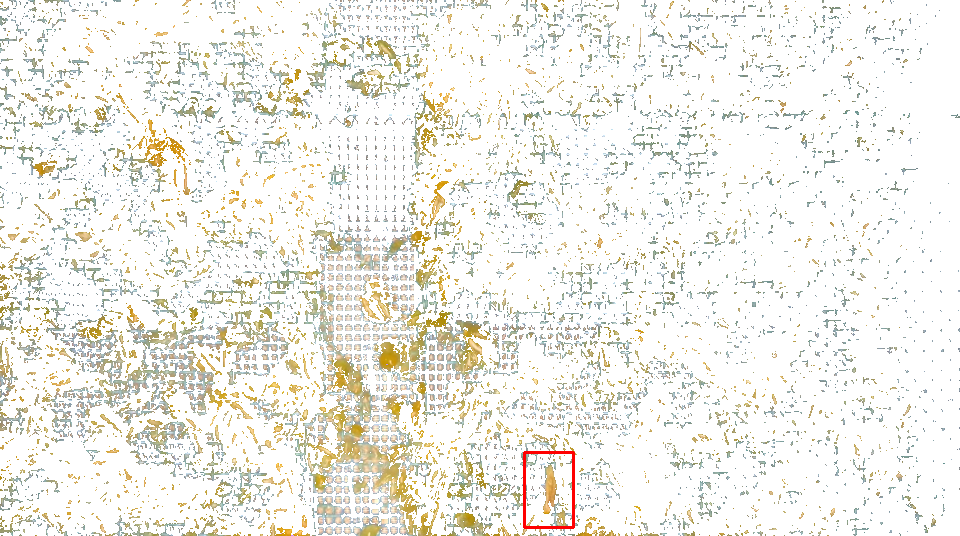

In [3]:
origin_image = cv2.imread(origin_image_p)
dsrnet_s_test_l = cv2.imread(dsrnet_s_test_l_p)
dsrnet_s_test_r = cv2.imread(dsrnet_s_test_r_p)
dsrnet_s_test_rr = cv2.imread(dsrnet_s_test_rr_p)

origin_image_hsv = cv2.cvtColor(origin_image, cv2.COLOR_BGR2HSV)

obj_mask = obj_masks[STEM]
obj_mask = cv2.resize(obj_mask, (origin_image.shape[1], origin_image.shape[0]))
obj_mask = cv2.cvtColor(obj_mask, cv2.COLOR_BGR2GRAY)
x, y, w, h = cv2.boundingRect(obj_mask)
M = 10
x, y, w, h = x - M, y - M, w + 2 * M, h + 2 * M


# diff = origin_image - dsrnet_s_test_l
diff = dsrnet_s_test_l

# 対象画像をバイナリ化し、マスク領域を抽出
mask = cv2.cvtColor(diff, cv2.COLOR_BGR2GRAY)
_, mask = cv2.threshold(mask, 127, 255, cv2.THRESH_BINARY)
Image.fromarray(mask)

masked = cv2.bitwise_and(origin_image, origin_image, mask=mask)

# 青色の部分を除外するために、青色のマスクを反転する
blue_mask = cv2.inRange(origin_image_hsv, COLOR_RANGE.blue.lower, COLOR_RANGE.blue.upper)
blue_mask_inv = cv2.bitwise_not(blue_mask)
hsv = cv2.bitwise_and(origin_image_hsv, origin_image_hsv, mask=blue_mask_inv)

masked = cv2.bitwise_and(masked, masked, mask=blue_mask_inv)

# masked = np.where(masked == 255, 0, masked)
masked = np.where(masked == 0, 255, masked)

masked = draw_bbox(masked, x, y, w, h, color=(0, 0, 255), thickness=2)

Image.fromarray(masked[:, :, ::-1])

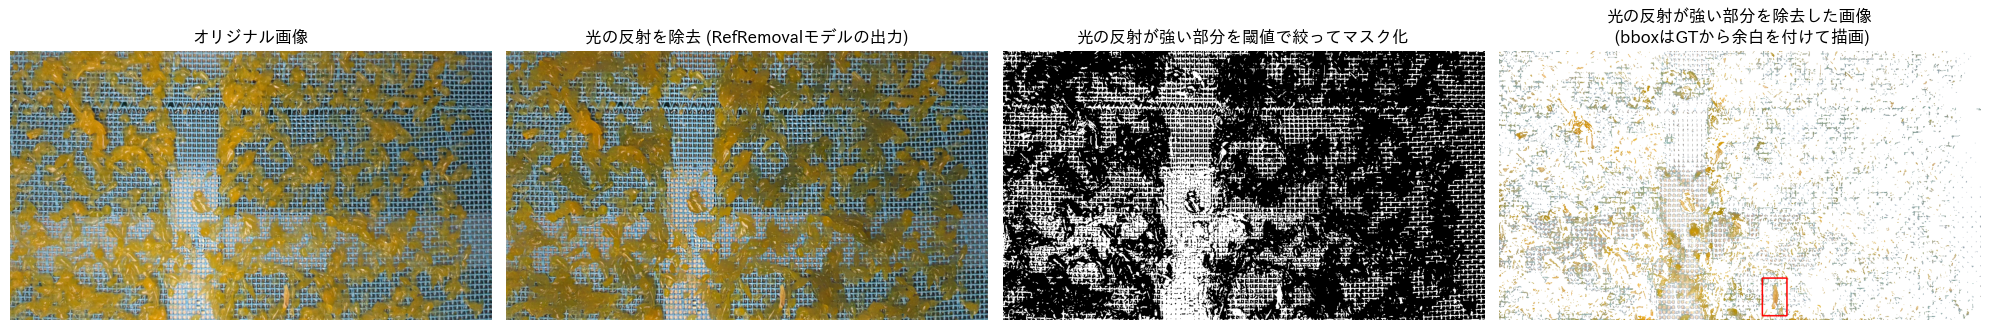

In [4]:
def display_images(original, reflection, mask, non_reflective):
    fig, axes = plt.subplots(1, 4, figsize=(20, 10))

    axes[0].imshow(original)
    axes[0].set_title("オリジナル画像")
    axes[0].axis("off")

    axes[1].imshow(reflection, cmap="gray")
    axes[1].set_title("光の反射を除去 (RefRemovalモデルの出力)")
    axes[1].axis("off")

    axes[2].imshow(mask, cmap="gray")
    axes[2].set_title("光の反射が強い部分を閾値で絞ってマスク化")
    axes[2].axis("off")

    axes[3].imshow(non_reflective)
    axes[3].set_title("光の反射が強い部分を除去した画像\n (bboxはGTから余白を付けて描画)")
    axes[3].axis("off")

    # plt.savefig(f"{STEM}.png", bbox_inches="tight")
    plt.tight_layout()
    plt.show()


display_images(
    origin_image[:, :, ::-1],
    dsrnet_s_test_l[:, :, ::-1],
    mask,
    masked[:, :, ::-1],
)